In [229]:
from matplotlib import pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import json
import os

In [230]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(BASE_DIR, "TMDB_5000")

In [231]:
MP_STYLE = os.path.join(BASE_DIR, "style.mplstyle")
plt.style.use(MP_STYLE)

In [232]:
dfs = {}

for file_name in os.listdir(DATA_DIR):
    dfs[file_name.split(".")[0]] = pd.read_csv(os.path.join(DATA_DIR, file_name))

for df in dfs:
    print(df)
    print(dfs.get(df).columns)
    print("\n")

tmdb_5000_credits
Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')


tmdb_5000_movies
Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')




In [233]:
joined_df = dfs.get("tmdb_5000_credits").rename(columns={"movie_id":"id"}).merge(dfs.get("tmdb_5000_movies").drop(columns=["title"]), on="id")
joined_df = joined_df[joined_df.status == "Released"][joined_df.budget > 1000][joined_df.revenue > 1000]

/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/3784794141.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  joined_df = joined_df[joined_df.status == "Released"][joined_df.budget > 1000][joined_df.revenue > 1000]


In [234]:
df = joined_df[["id", "title", "budget", "revenue", "genres", "runtime", "cast", "crew"]]
df["net_profit"] = df.revenue - df.budget
df["ROI"] = df.net_profit / df.budget

/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/2853587483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["net_profit"] = df.revenue - df.budget
/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/2853587483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ROI"] = df.net_profit / df.budget


In [235]:
def remove_outliers(df:pd.DataFrame, columns:list) -> pd.DataFrame:
    new_df = df

    for column in columns:
        col = new_df[column]
        Q1 = col.quantile(0.25)
        Q3 = col.quantile(0.75)
        IQR = Q3 - Q1

        new_df = new_df[new_df[column] < Q3 + 1.5 * IQR]
        new_df = new_df[new_df[column] > Q1 - 1.5 * IQR]

    return new_df    

In [236]:
corrs = [["budget", "net_profit"], ["budget", "ROI"], ["runtime", "net_profit"], ["runtime", "ROI"]]


for corr in corrs:
    print(corr)
    print(stats.spearmanr(df[corr[0]], df[corr[1]]))
    # plt.scatter(df[corr[0]], df[corr[1]])
    # plt.show()
    # plt.clf()
    print("\n")

['budget', 'net_profit']
SpearmanrResult(correlation=0.34086147420925433, pvalue=3.78098498365987e-88)


['budget', 'ROI']
SpearmanrResult(correlation=-0.13590489400211508, pvalue=1.051670348290517e-14)


['runtime', 'net_profit']
SpearmanrResult(correlation=0.15719602213415623, pvalue=3.2908692794775684e-19)


['runtime', 'ROI']
SpearmanrResult(correlation=0.041780970908973966, pvalue=0.017918866388060815)




In [237]:
def expand_column(df:pd.DataFrame, column:str) -> pd.DataFrame:
    new_df = df.copy()
    new_df[column] = new_df[column].apply(json.loads)
    return new_df.explode(column, ignore_index=True).dropna(subset=column)

In [238]:
# MAKE GENRES_DF
def get_genre(dic:dict) -> str:
    return dic.get("name")

genres_df = expand_column(df, "genres").drop(columns=["cast", "crew"])
genres_df.genres = genres_df.genres.apply(get_genre)

In [239]:
# MAKE ACTORS_DF
def get_actor(dic:dict) -> str:
    return dic.get("name")

actors_df = expand_column(df, "cast").drop(columns=["genres", "crew"]).rename(columns={"cast":"actors"})
actors_df.actors = actors_df.actors.apply(get_actor)
actors_df = actors_df[actors_df.actors.duplicated()] # get only actors who have been in > 1 film

In [245]:
# MAKE CREW_DF
crew_df = expand_column(df.drop(columns=["genres", "cast"]), "crew")
crewmem_info_df = crew_df.crew.apply(pd.Series)
crew_df = pd.concat([crew_df, crewmem_info_df[["job", "name"]]], axis=1).drop(columns=["crew"])


1
2
3


/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/2694208878.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")
/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/2694208878.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")


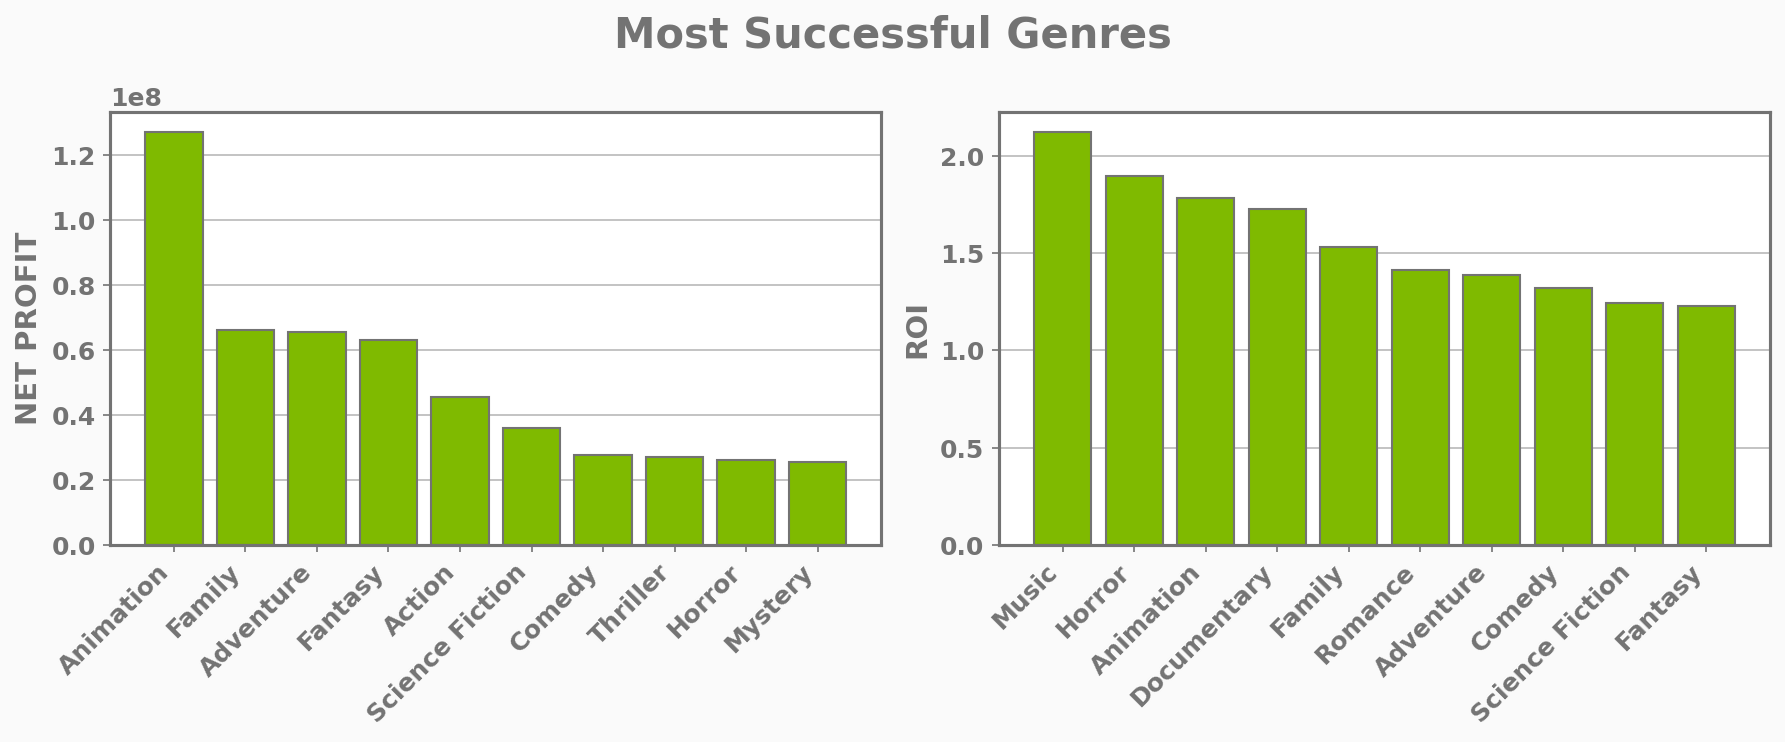

In [241]:
# GENRE ANALYSIS

fig, axs = plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=(12,5))
fig.suptitle("Most Successful Genres")

top_genres = {}

for idx, marker in enumerate(["net_profit", "ROI"]):
    test = genres_df.groupby("genres").median().sort_values(marker, ascending=False)[:10]
    top_genres[marker] = test.index
    
    ax = axs[idx]
    ax.bar(test.index, height=test[marker])
    # ax.set_title("Most Valuable Genres")
    ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")
    ax.set_ylabel(marker.replace("_", " ").upper())

actors
Johnny A. Sanchez    284335608.0
Robert Broyles       283788635.0
Jae Head             280208309.0
Nancy DeMars         280170008.0
Gilbert R. Hill      279965036.0
Marni Nixon          278014286.0
Name: net_profit, dtype: float64
actors
Brian Wimmer       8.999738
Richard Young      8.968372
Jiang Wu           8.941651
Hawthorne James    8.918541
Name: ROI, dtype: float64


/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/1918674266.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")
/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/1918674266.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")


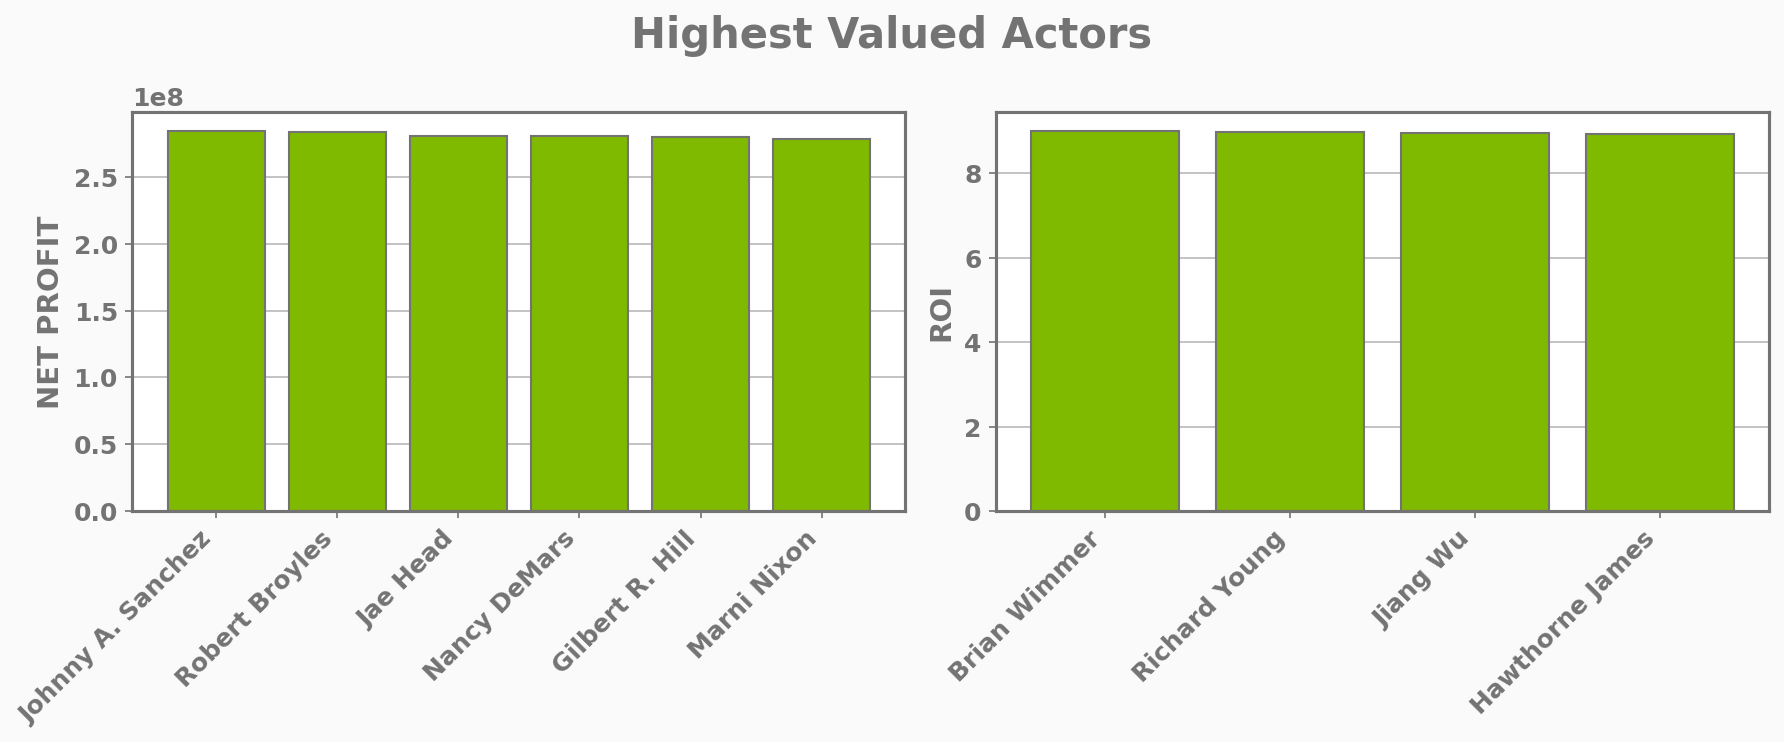

In [242]:
# CAST/ACTORS ANALYSIS

fig, axs = plt.subplots(nrows=1, ncols=2, tight_layout=True, figsize=(12,5))
fig.suptitle("Highest Valued Actors")

for idx, marker in enumerate(["net_profit", "ROI"]):
    test = remove_outliers(actors_df, [marker]).groupby("actors").median().sort_values(marker, ascending=False)[:10].drop_duplicates(subset=marker)

    print(test[marker])
    ax = axs[idx]
    ax.bar(test.index, height=test[marker])
    ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")
    ax.set_ylabel(marker.replace("_", " ").upper())

# cant do

/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/1871481867.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")
/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/1871481867.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")
/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/1871481867.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")
/var/folders/z_/crwkmnv94dd46zfmf05zrpsm0000gn/T/ipykernel_72361/1871481867.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")


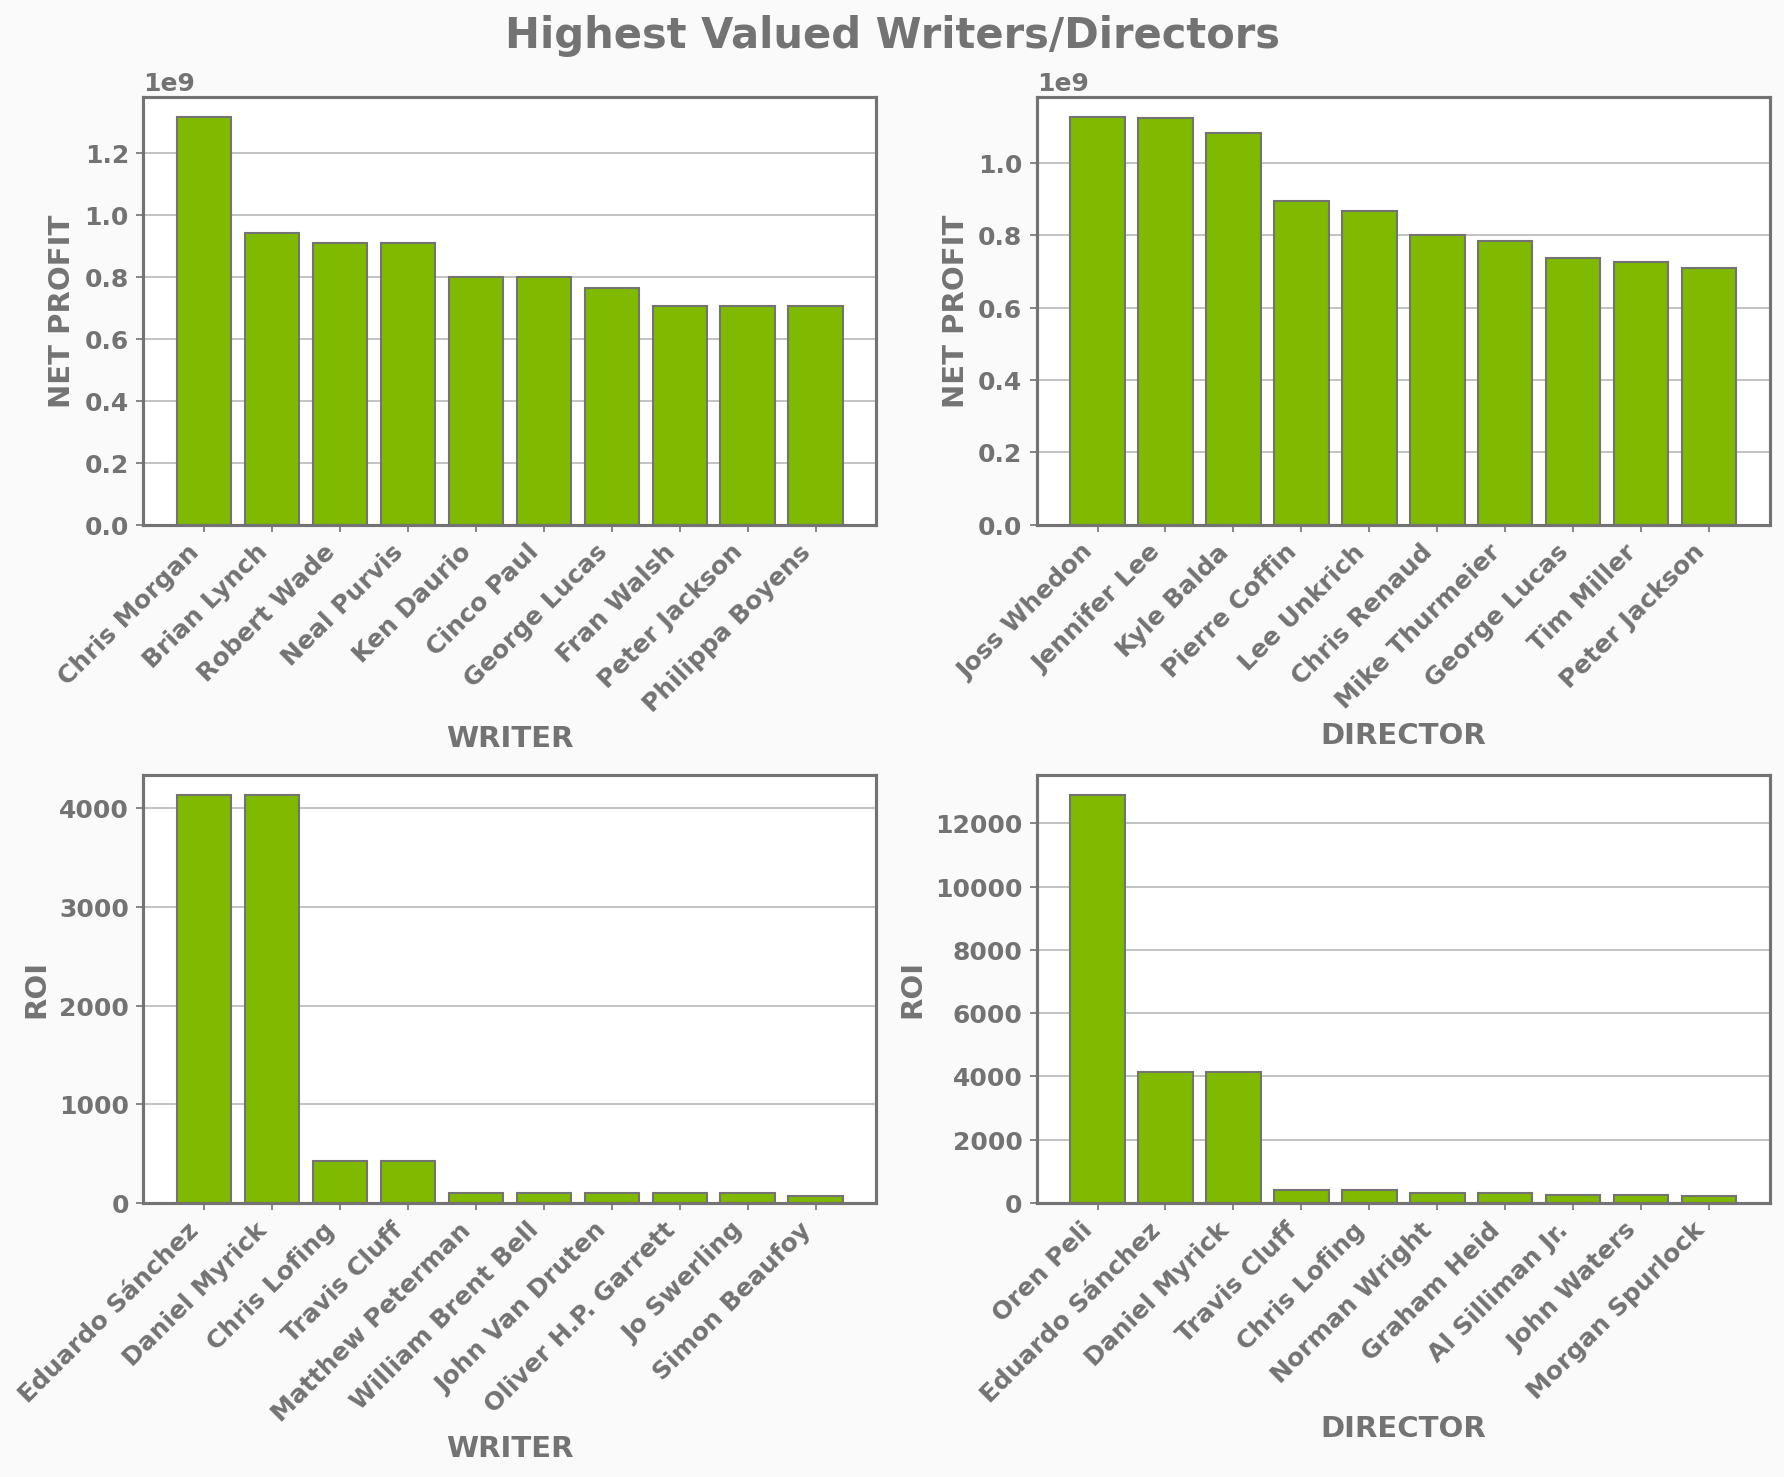

In [243]:
# ACTORS / WRITERS ANALYSIS

fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True, figsize=(12,10))
fig.suptitle("Highest Valued Writers/Directors")

for idx, marker in enumerate(["net_profit", "ROI"]):
    for idx2, job in enumerate(["Writer", "Director"]):
        test = crew_df[crew_df.job == job]
        test = test.groupby("name").median().sort_values(marker, ascending=False)[:10]
        # print(marker, job)
        # print(test[["net_profit", "ROI"]])

        ax = axs[idx][idx2]
        x = ax.bar(test.index, height=test[marker])
        # ax.bar_label(x, rotation=25)
        ax.set_xticklabels(test.index, rotation = 45, ha="right", va="top")
        ax.set_ylabel(marker.replace("_", " ").upper())
        ax.set_xlabel(job.upper())

In [244]:
x = genres_df[["id", "genres"]].merge(crew_df[["id", "name", "job", "net_profit", "ROI"]], on="id")

for marker in ["net_profit", "ROI"]:
    for genre in top_genres.get(marker):
        for job in ["Writer", "Director"]:
            y = x[x.job == job]
            y = y[y[marker] > y[marker].quantile(.99)]

            y = y[["genres", "name", marker]].groupby(["genres", "name"]).median()

            if genre in y.index:
                print(genre, job + "s by", marker)
                print(y.loc[genre].sort_values(marker, ascending=False), end="\n\n\n")

Animation Writers by net_profit
              net_profit
name                    
Brian Lynch  941844635.0
Cinco Paul   800958308.0
Ken Daurio   800958308.0


Animation Directors by net_profit
                  net_profit
name                        
Chris Buck      1.124219e+09
Jennifer Lee    1.124219e+09
Kyle Balda      1.082731e+09
Pierre Coffin   9.887464e+08
Lee Unkrich     8.669697e+08
Chris Renaud    8.478601e+08
Andrew Stanton  8.463355e+08


Family Writers by net_profit
              net_profit
name                    
Brian Lynch  941844635.0
Cinco Paul   800958308.0
Ken Daurio   800958308.0


Family Directors by net_profit
                  net_profit
name                        
Chris Buck      1.124219e+09
Jennifer Lee    1.124219e+09
Kyle Balda      1.082731e+09
Pierre Coffin   9.887464e+08
Lee Unkrich     8.669697e+08
Chris Columbus  8.514756e+08
Chris Renaud    8.478601e+08
Andrew Stanton  8.463355e+08
Tim Burton      8.254911e+08


Adventure Writers by net_profit
    